In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/DMC20_Data/c3ai

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime

Ensure that you have a recent version of pandas (>= 1.0.0).

In [4]:
print("pandas version", pd.__version__)
assert pd.__version__[0] >= "1", "To use this notebook, upgrade to the newest version of pandas. See https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html for details."


pandas version 1.1.4


Read dataset

In [5]:
city_file = pd.read_excel('C3-ai-Location-IDs.xlsx', sheet_name="City IDs", skiprows=2)
city_file.fillna(0,inplace=True)
city_file.replace('X', 1, inplace= True) # data accessible

In [6]:
city_file.head()

City id  ... US CDC: Select Demographic Characteristics
0              BuenosAires_Argentina  ...                                          0
1  Adelaide_SouthAustralia_Australia  ...                                          0
2      Brisbane_Queensland_Australia  ...                                          0
3       Melbourne_Victoria_Australia  ...                                          0
4   Perth_WesternAustralia_Australia  ...                                          0

[5 rows x 14 columns]

In [7]:
country_file = pd.read_excel('C3-ai-Location-IDs.xlsx', sheet_name="Country IDs", skiprows=2)
country_file.fillna(0,inplace=True)
country_file.replace('X', 1, inplace= True) # data accessible

In [8]:
state_file = pd.read_excel('C3-ai-Location-IDs.xlsx', sheet_name="Province & State IDs", skiprows=2)
state_file.fillna(0,inplace=True)
state_file.replace('X', 1, inplace= True) # data accessible

In [9]:
county_file = pd.read_excel('C3-ai-Location-IDs.xlsx', sheet_name="County IDs", skiprows=2)
county_file.fillna(0,inplace=True)
county_file.replace('X', 1, inplace= True) # data accessible

<a id="helpers"></a>
## Helper methods for accessing the API

The helper methods in `c3aidatalake.py` convert a JSON response from the C3.ai APIs to a Pandas DataFrame. You may wish to view the code in `c3aidatalake.py` before using the quickstart examples.

In [10]:
import c3aidatalake

## County comparison

We will compare data from the following datasets across Bay Area counties:
- Confirmed case counts from Johns Hopkins University: COVID-19 Data Repository
- Walking, driving, and transit mobility indices from Apple: COVID-19 Mobility Trends
- Parks, residential, retail, grocery, transit stations, and workplaces mobility from Google: COVID-19 Community Mobility Reports
- Device exposure indices from PlaceIQ Exposure Indices

In [11]:
today = pd.Timestamp.now() - datetime.timedelta(days = 7)
today = today.strftime("%Y-%m-%d")

locations = [
    "SanFrancisco_California_UnitedStates",
    "SanMateo_California_UnitedStates",
    "SantaClara_California_UnitedStates",
    "Alameda_California_UnitedStates"
]

metrics = [
    "JHU_ConfirmedCases",
    "JHU_ConfirmedDeaths",
    "Apple_TransitMobility",
    "Apple_WalkingMobility", 
    "Apple_DrivingMobility",
    "Google_ParksMobility",
    "Google_ResidentialMobility",
    "Google_GroceryMobility",
    "Google_TransitStationsMobility",
    "Google_RetailMobility",
    "Google_WorkplacesMobility",
    "PlaceIQ_DeviceExposure_Adjusted"
]

complete_timeseries = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : locations,
            "expressions" : metrics,
            "start" : "2020-02-15",
            "end" : today,
            "interval" : "DAY",
        }
    },
    get_all = True
)

complete_timeseries

dates  ... SanMateo_California_UnitedStates.PlaceIQ_DeviceExposure_Adjusted.missing
0  2020-02-15  ...                                                  0                      
0  2020-02-16  ...                                                  0                      
0  2020-02-17  ...                                                  0                      
0  2020-02-18  ...                                                  0                      
0  2020-02-19  ...                                                  0                      
..        ...  ...                                                ...                      
0  2020-11-04  ...                                                  0                      
0  2020-11-05  ...                                                100                      
0  2020-11-06  ...                                                100                      
0  2020-11-07  ...                                                100                      
0  2020-11-08  ...                                                100                      

[268 rows x 97 columns]

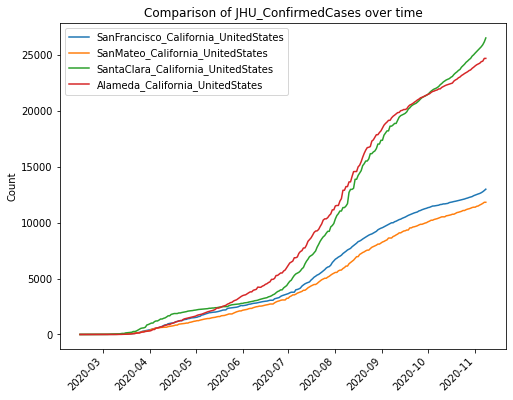

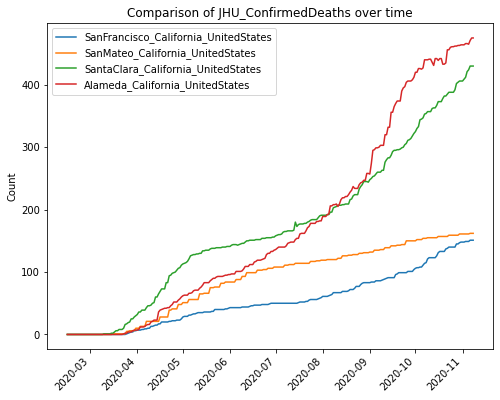

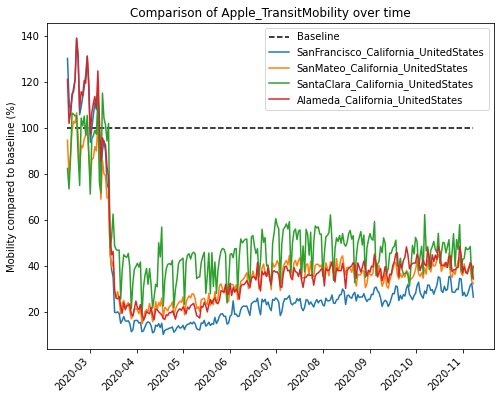

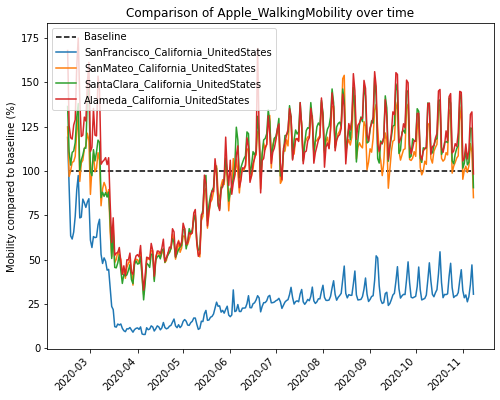

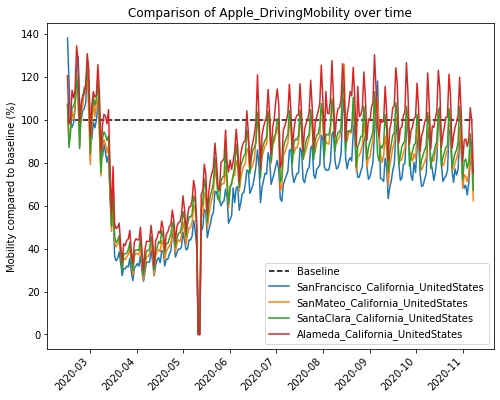

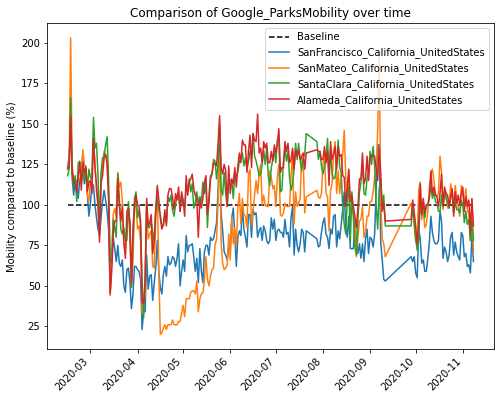

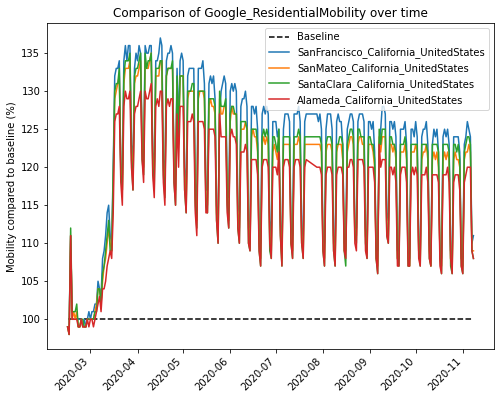

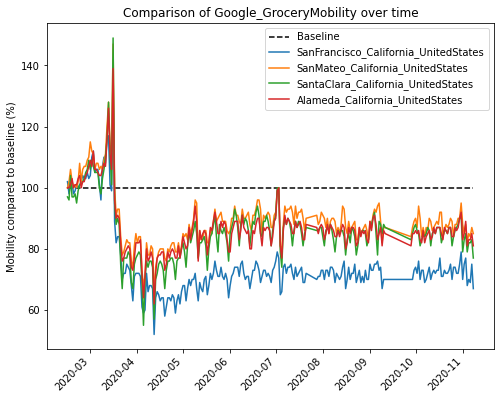

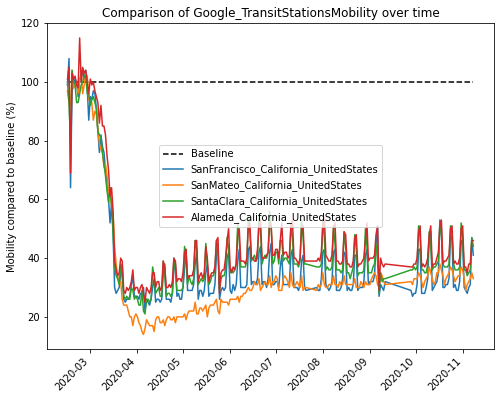

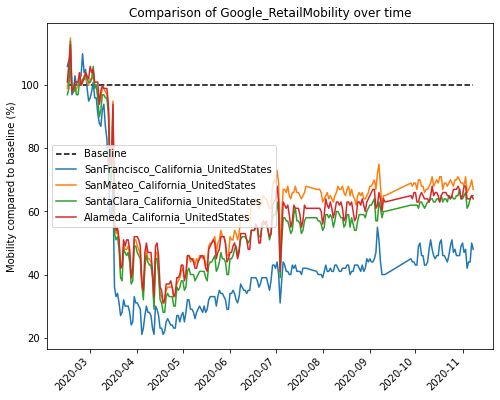

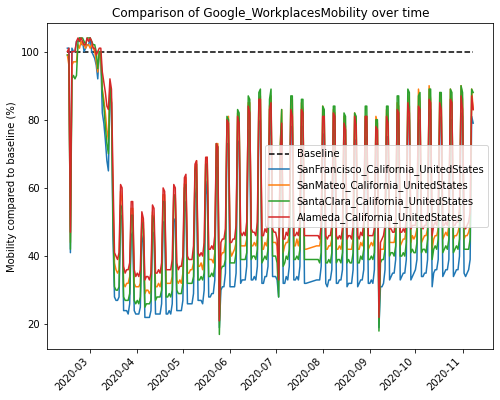

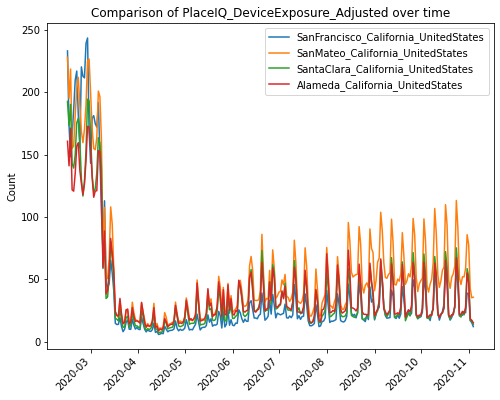

In [12]:
for metric in metrics:
    plt.figure(figsize = (8, 6))

    if "Mobility" in metric:
        plt.plot(
            complete_timeseries["dates"],
            [100 for d in complete_timeseries["dates"]],
            label = "Baseline",
            linestyle = "dashed",
            color = "black"
        )

    for location in locations:
        data_col = location + "." + metric + ".data"
        missing_col = location + "." + metric + ".missing"

        missing = list(complete_timeseries[missing_col])
        data = [list(complete_timeseries[data_col])[i] for i in range(len(complete_timeseries[data_col])) if missing[i] < 100]
        dates = [list(complete_timeseries["dates"])[i] for i in range(len(complete_timeseries["dates"])) if missing[i] < 100]

        plt.plot(
            dates,
            data,
            label = location
        )

    plt.legend()
    plt.xticks(rotation = 45, ha = "right")
    if "Mobility" in metric:
        plt.ylabel("Mobility compared to baseline (%)")
    else:
        plt.ylabel("Count")
    plt.title("Comparison of " + metric + " over time")
    plt.show()

In general, Alemeda tends to have slightly higher mobility and device exposure. Google retail mobility is substantially lower in San Francisco than other counties.

Let's compare case counts and mobility directly. You can edit the locations and metrics below to view other comparisons.

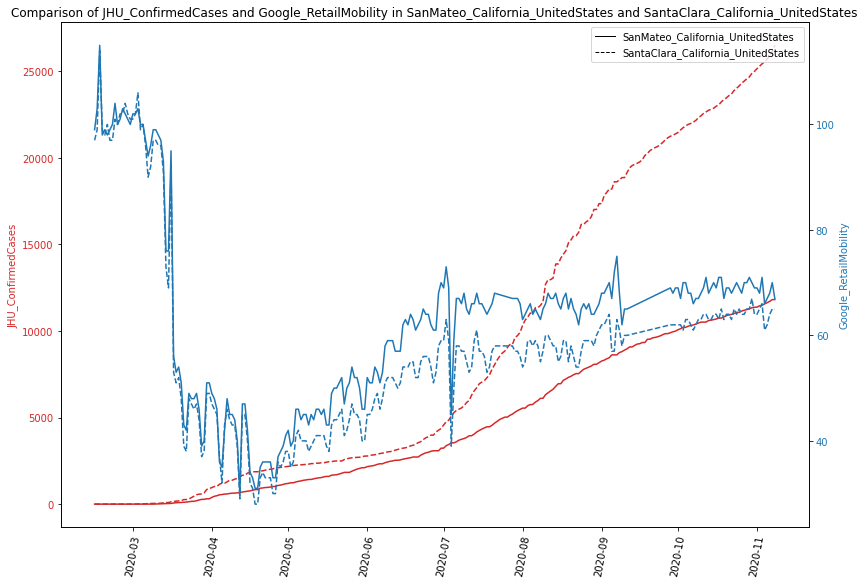

In [13]:
from matplotlib.lines import Line2D

metric1 = "JHU_ConfirmedCases"
metric2 = "Google_RetailMobility"

location1 = "SanMateo_California_UnitedStates"
location2 = "SantaClara_California_UnitedStates"

all_locations = [location1, location2]
linestyles = ["solid", "dashed"]

fig, ax1 = plt.subplots(figsize = (12, 8))
color = 'tab:red'
ax1.set_ylabel(metric1, color = color)
ax1.tick_params(axis='y', labelcolor = color)

for i, location in enumerate(all_locations):
    data_col = location + "." + metric1 + ".data"
    missing_col = location + "." + metric1 + ".missing"

    missing = list(complete_timeseries[missing_col])
    data = [list(complete_timeseries[data_col])[i] for i in range(len(complete_timeseries[data_col])) if missing[i] < 100]
    dates = [list(complete_timeseries["dates"])[i] for i in range(len(complete_timeseries["dates"])) if missing[i] < 100]

    ax1.plot(
        dates,
        data,
        ls = linestyles[i],
        color = color,
        label = location
    )


ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel(metric2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

for i, location in enumerate(all_locations):
    data_col = location + "." + metric2 + ".data"
    missing_col = location + "." + metric2 + ".missing"

    missing = list(complete_timeseries[missing_col])
    data = [list(complete_timeseries[data_col])[i] for i in range(len(complete_timeseries[data_col])) if missing[i] < 100]
    dates = [list(complete_timeseries["dates"])[i] for i in range(len(complete_timeseries["dates"])) if missing[i] < 100]

    ax2.plot(
        dates,
        data,
        ls = linestyles[i],
        color = color,
        label = location
    )

plt.legend([
    Line2D([0], [0], color = "black", linestyle = linestyles[0], lw=1),
    Line2D([0], [0], color = "black", linestyle = linestyles[1], lw=1)
], all_locations)

ax1.tick_params(axis='x', labelrotation = 80)

fig.tight_layout()
plt.title("Comparison of " + metric1 + " and " + metric2 + " in " + location1 + " and " + location2)
plt.show()

These visualizations show the options to manipulate and use mobility and case count data from the C3.ai COVID-19 Data Lake. For full analysis of these data, see the [R Deep Dive notebook](https://c3.ai/covid-19-api-documentation/#section/Quickstart-Guide). In bringing together data sets from disparate sources, the C3.ai COVID-19 Data Lake permits in-depth and real-time data exploration. 

If any publications or research results are derived in full or in part from the C3.ai COVID-19 Data Lake, please make sure to credit the C3.ai COVID-19 Data Lake by referencing the case study at https://c3.ai/customers/covid-19-data-lake/.

# Global trends of Covid spread

In [14]:
today = pd.Timestamp.now() - datetime.timedelta(days = 7)
today = today.strftime("%Y-%m-%d")

locations = [
    "Hubei_China",
    "NewYork_UnitedStates",
]

metrics = [
    "JHU_ConfirmedCases",
    "JHU_ConfirmedDeaths",
]

complete_timeseries = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids": locations,
            "expressions" : metrics,
            "start" : "2020-02-15",
            "end" : today,
            "interval" : "DAY",
        }
    },
    get_all = True
)

complete_timeseries.head()

dates  ... NewYork_UnitedStates.JHU_ConfirmedDeaths.missing
0 2020-02-15  ...                                                0
0 2020-02-16  ...                                                0
0 2020-02-17  ...                                                0
0 2020-02-18  ...                                                0
0 2020-02-19  ...                                                0

[5 rows x 9 columns]

In [16]:
complete_timeseries.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


dates  ...  NewYork_UnitedStates.JHU_ConfirmedDeaths.missing
count                   268  ...                                             268.0
unique                  268  ...                                               1.0
top     2020-03-13 00:00:00  ...                                               0.0
freq                      1  ...                                             268.0
first   2020-02-15 00:00:00  ...                                               NaN
last    2020-11-08 00:00:00  ...                                               NaN

[6 rows x 9 columns]

In [19]:
import numpy as np
# !pip install -q bokeh==2.2.3
from bokeh.layouts import row, column
from bokeh.models import CustomJS, Slider
from bokeh.plotting import figure, output_file, show, ColumnDataSource

x = np.linspace(0, 10, 500)
y = np.sin(x)

source = ColumnDataSource(data=dict(x=x, y=y))

plot = figure(y_range=(-10, 10), plot_width=400, plot_height=400)

plot.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

amp_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")
freq_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Frequency")
phase_slider = Slider(start=0, end=6.4, value=0, step=.1, title="Phase")
offset_slider = Slider(start=-5, end=5, value=0, step=.1, title="Offset")

callback = CustomJS(args=dict(source=source, amp=amp_slider, freq=freq_slider, phase=phase_slider, offset=offset_slider),
                    code="""
    const data = source.data;
    const A = amp.value;
    const k = freq.value;
    const phi = phase.value;
    const B = offset.value;
    const x = data['x']
    const y = data['y']
    for (var i = 0; i < x.length; i++) {
        y[i] = B + A*Math.sin(k*x[i]+phi);
    }
    source.change.emit();
""")

amp_slider.js_on_change('value', callback)
freq_slider.js_on_change('value', callback)
phase_slider.js_on_change('value', callback)
offset_slider.js_on_change('value', callback)

layout = row(
    plot,
    column(amp_slider, freq_slider, phase_slider, offset_slider),
)

output_file("slider.html", title="slider.py example")

show(layout)



In [ ]:
script, div = components(layout)

In [ ]:
div

In [ ]:
script

# Next plots to make:
1. mobility map (grocery, park, resident, work, etc)
2. social distance restrictions map
3. model on intervention/hospital capacity, etc

In [ ]:
locations = list(country_file["Country id"])#[:20]

In [ ]:
# locations = list(state_file["Province or State id"])#[:20]

In [ ]:
today = pd.Timestamp.now() - datetime.timedelta(days = 7)
today = today.strftime("%Y-%m-%d")

# locations = [
#     "China"
# ]

metrics = [
    "Apple_WalkingMobility", 
]

complete_timeseries = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : locations,
            "expressions" : metrics,
            "start" : "2020-02-15",
            "end" : today,
            "interval" : "DAY",
        }
    },
    get_all = True
)

complete_timeseries

dates  ... Yemen.Apple_WalkingMobility.missing
0  2020-02-15  ...                                 100
0  2020-02-16  ...                                 100
0  2020-02-17  ...                                 100
0  2020-02-18  ...                                 100
0  2020-02-19  ...                                 100
..        ...  ...                                 ...
0  2020-10-27  ...                                 100
0  2020-10-28  ...                                 100
0  2020-10-29  ...                                 100
0  2020-10-30  ...                                 100
0  2020-10-31  ...                                 100

[260 rows x 381 columns]

In [ ]:
# convert to mobility df
# df_mobility: dates | country | data

index = pd.MultiIndex.from_product([list(complete_timeseries["dates"]), locations], names = ["dates", "country"]) # cartesian product
df_mobility = pd.DataFrame(index = index).reset_index()

In [ ]:
df_mobility["states"] = df_mobility["country"].str.split('_').str[0]
df_mobility["country2"] = df_mobility["country"].str.split('_').str[1]

In [ ]:
data = []
for i in range(len(df_mobility)):
  row = df_mobility["dates"][i]
  col = df_mobility["country"][i] + "." + metrics[0] + ".data"
  data.append(complete_timeseries.loc[complete_timeseries["dates"] == row][col][0])

df_mobility["data"] = data

In [ ]:
df_mobility.head()

dates       country        states  country2    data
0 2020-02-15  UnitedStates  UnitedStates       NaN  158.55
1 2020-02-15         China         China       NaN    0.00
2 2020-02-15   Afghanistan   Afghanistan       NaN    0.00
3 2020-02-15       Albania       Albania       NaN  108.40
4 2020-02-15       Algeria       Algeria       NaN    0.00

In [ ]:
df_mobility.loc[df_mobility["country2"] == 'US']

In [ ]:
df_mobility["country2"].unique()

array([nan])

In [ ]:
import plotly.express as px
fig = px.choropleth(df_mobility, locations="country", 
                    locationmode='country names', color="data", 
                    hover_name="country", range_color=[0, df_mobility["data"].max()/2], 
                    color_continuous_scale="peach", 
                    title='Countries with mobility score')
fig.show()

In [ ]:
import plotly.express as px
fig = px.choropleth(df_mobility, locations="states", 
                    locationmode='USA-states', color="data", 
                    hover_name="states", range_color=[0, df_mobility["data"].max()/2], 
                    color_continuous_scale="peach", 
                    title='Countries with mobility score')
fig.show()

In [ ]:
# dynamic map
df_mobility['dates'] = df_mobility['dates'].apply(str)

fig = px.scatter_geo(df_mobility, locations="country", locationmode='country names', 
                     color="data", size='data', hover_name="country", 
                     hover_data=['data'],
                     range_color= [0, df_mobility['data'].max()/3], 
                     projection="natural earth", animation_frame="dates", 
                     title='COVID-19: Mobility Changes Over Time', color_continuous_scale="portland")
# fig.update(layout_coloraxis_showscale=False)
fig.show()

In [ ]:
import plotly.figure_factory as ff

import numpy as np
import pandas as pd
# !pip install plotly-geo

configure_plotly_browser_state()

df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/laucnty16.csv')
df_sample['State FIPS Code'] = df_sample['State FIPS Code'].apply(lambda x: str(x).zfill(2))
df_sample['County FIPS Code'] = df_sample['County FIPS Code'].apply(lambda x: str(x).zfill(3))
df_sample['FIPS'] = df_sample['State FIPS Code'] + df_sample['County FIPS Code']

colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
    "#08519c", "#0b4083", "#08306b"
]
endpts = list(np.linspace(1, 12, len(colorscale) - 1))
fips = df_sample['FIPS'].tolist()
values = df_sample['Unemployment Rate (%)'].tolist()


fig = ff.create_choropleth(
    fips=fips, values=values, scope=['usa'],
    binning_endpoints=endpts, colorscale=colorscale,
    show_state_data=False,
    show_hover=True,
    asp = 2.9,
    title_text = 'USA by Unemployment %',
    legend_title = '% unemployed'
)
fig.layout.template = None
fig.show()

**datawrapper visualizations**

In [ ]:
!pip install datawrapper
from datawrapper import Datawrapper
dw = Datawrapper(access_token = "Z3IvKkUAJdKvcOvu2fZWc9UgZzVm6rd8vY1DxLAvjmWeBig2rfXOmQWWei42fYgv")

In [ ]:
dw.account_info()

{'chartCount': 33,
 'email': 'qypeng12@outlook.com',
 'id': 262626,
 'language': 'en-US',
 'name': None,
 'role': 'editor',
 'url': '/v3/users/262626'}

In [ ]:
california_chart = dw.create_chart(title = "California's Recently Arrived Immigrants", chart_type = 'd3-bars-stacked', data = country_file)

New chart d3-bars-stacked created!


In [ ]:
dw.update_description(
	california_chart['id'],
	source_name = 'IPUMS',
	source_url = 'https://ipums.org',
	byline = 'Sergio Sánchez',
)

Chart updated!


In [ ]:
properties = {
	'visualize' : {
    	'thick': True,
    	'custom-colors': {
        	'Advanced degree': '#15607a',
        	"Bachelor's degree": '#1d81a2',
        	'High school or less': '#dadada'
    	},
    }
}
dw.update_metadata(california_chart['id'], properties)

Chart's metadata updated!


In [ ]:
dw.publish_chart(california_chart['id'])

In [ ]:
properties = {
    'visualize' : {
        'thick': True,
        'custom-colors': {
            'Advanced degree': '#15607a',
            "Bachelor's degree": '#1d81a2',
            'High school or less': '#dadada'
        },
    }
}
# For each county
for county in data['county'].unique():
    if pd.notna(county):
    # prep data
        mask_county = data['county'] == county
        dw_data = data[mask_county].pivot_table(columns = 'edu-three-cat', index = 'year', values = 'perwt', aggfunc='sum')
        dw_data = dw_data.apply(lambda x: (x / x.sum()) * 100, axis = 1)
        dw_data.reset_index(inplace = True)
        # publish chart
        county_chart = dw.create_chart(title = f"{county} recently arrived immigrants", chart_type = "d3-bars-stacked", data = dw_data, folder_id=13942)
        dw.update_description(
            county_chart['id'],
            source_name = 'IPUMS',
            source_url = 'https://ipums.org/',
            byline = 'Sergio Sanchez',
        )
        dw.update_metadata(county_chart['id'], properties)
        dw.publish_chart(county_chart['id'], display = False)
    else:
        print("Skipping! Null value.")

In [ ]:
dw.get_iframe_code(california_chart['id'])